In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost with Mean Encoding (Grouped, DGI Label)
Mean Encode NAICS grouped by cluster

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
from sklearn.preprocessing import TargetEncoder

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [6]:
import sklearn as sk
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [7]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

##### Get loans data, append clusters

In [8]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [9]:
sba_loans.filter(like='NAICS').columns

Index(['NAICS', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc', 'NAICS_num',
       'menc_NAICS', 'cenc_NAICS', 'menc_grp_NAICS'],
      dtype='object')

In [10]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('69_DATA_embeddings_tsne_naics.parquet'))

In [11]:
embed_df.columns

Index(['source', 'emb_000', 'emb_001', 'emb_002', 'emb_003', 'emb_004',
       'emb_005', 'emb_006', 'emb_007', 'NAICS_2', 'NAICS_sector',
       'NAICS_sector_sel', 'NAICS_sector_desc', 'NAICS_sector_comb',
       'NAICS_sector_filt', 'tsne_0', 'tsne_1', 'NAICS_orig', 'cluster',
       'NC__0', 'NC__1', 'NC__2', 'NC__3', 'NC__4', 'NC__5', 'NC__6', 'NC__7',
       'NC__8'],
      dtype='object')

In [12]:
sba_loans = sba_loans.drop(columns = 'cluster', errors='ignore') \
    .merge(embed_df[['NAICS_orig', 'cluster']].rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

## Fit the Target Encoder(s)

In [13]:
# Per sector function
def mean_enc_grp(data):
    naics_grp_encoder = TargetEncoder(target_type='binary', random_state=3453)
    naics_grp_encoder.set_output(transform='pandas')
    
    train_out = naics_grp_encoder.fit_transform(data[data['dset'] == 'train'][['NAICS']], 
                      data[data['dset'] == 'train']['target'])
    other_out= naics_grp_encoder.transform(data[data['dset'] != 'train'][['NAICS']])
    out_data = pd.concat([train_out, other_out], axis=0).sort_index()
    out_data.columns = ['menc_clus_NAICS']
    return out_data

In [14]:
grouped = sba_loans.groupby('cluster')

In [15]:
sba_loans = pd.concat([sba_loans.drop(columns='menc_clus_NAICS', errors='ignore'),
                       pd.concat([mean_enc_grp(g) for n, g in grouped])],
                      axis=1)

In [16]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

#### Set the predictor features.  Inlcude the mean-encoded NAICS

In [17]:
predictor_features = setup.predictor_features + ['menc_clus_NAICS']
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_clus_NAICS']


In [18]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,menc_clus_NAICS,target
NoEmp,1.000000,0.052510,-0.009243,0.093125,-0.038672,0.002058,0.006517,-0.025460,-0.027838
CreateJob,0.052510,1.000000,-0.046967,0.101755,0.028831,0.009019,0.036918,0.003241,-0.009540
LowDoc,-0.009243,-0.046967,1.000000,-0.133731,0.154037,-0.119292,0.039258,-0.076327,-0.076836
DisbursementGross,0.093125,0.101755,-0.133731,1.000000,-0.067410,-0.006023,0.082087,-0.191027,-0.122857
new_business,-0.038672,0.028831,0.154037,-0.067410,1.000000,-0.046626,0.136142,0.026032,0.014277
urban_flag,0.002058,0.009019,-0.119292,-0.006023,-0.046626,1.000000,-0.004093,0.060539,0.054391
franchise_flag,0.006517,0.036918,0.039258,0.082087,0.136142,-0.004093,1.000000,0.032100,-0.011047
menc_clus_NAICS,-0.025460,0.003241,-0.076327,-0.191027,0.026032,0.060539,0.032100,1.000000,0.230914
target,-0.027838,-0.009540,-0.076836,-0.122857,0.014277,0.054391,-0.011047,0.230914,1.000000


In [19]:
with open(Path(setup.temp_path).joinpath('71_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [20]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [21]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [22]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [23]:
xgb_model = xgb_model.set_params(**xgb_params)

In [24]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.49847	validation_1-logloss:0.50132
[1]	validation_0-logloss:0.49104	validation_1-logloss:0.49386
[2]	validation_0-logloss:0.48488	validation_1-logloss:0.48766
[3]	validation_0-logloss:0.47963	validation_1-logloss:0.48236
[4]	validation_0-logloss:0.47510	validation_1-logloss:0.47779
[5]	validation_0-logloss:0.47123	validation_1-logloss:0.47391
[6]	validation_0-logloss:0.46794	validation_1-logloss:0.47065
[7]	validation_0-logloss:0.46513	validation_1-logloss:0.46784
[8]	validation_0-logloss:0.46276	validation_1-logloss:0.46545
[9]	validation_0-logloss:0.46072	validation_1-logloss:0.46343
[10]	validation_0-logloss:0.45894	validation_1-logloss:0.46165
[11]	validation_0-logloss:0.45735	validation_1-logloss:0.46007
[12]	validation_0-logloss:0.45594	validation_1-logloss:0.45872
[13]	validation_0-logloss:0.45478	validation_1-logloss:0.45758
[14]	validation_0-logloss:0.45374	validation_1-logloss:0.45654
[15]	validation_0-logloss:0.45285	validation_1-logloss:0.45568
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
train_df['target'].value_counts()

target
0    339167
1     86427
Name: count, dtype: int64

##### Save the model

In [26]:
xgb_model.save_model(Path(setup.temp_path).joinpath('71_MODEL_xgboost.json'))

In [27]:
with open(Path(setup.temp_path).joinpath('71_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [28]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [29]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.183791,0.114927,0.017154,0.622591,0.169810
1,0.282342,0.108547,0.017154,0.653110,0.286701


## Decision Threshold
Max f1, on training data

In [30]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [31]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [32]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('71_REPORT_thresh_tune.csv'), index=False)

In [33]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.450895
11,0.22,0.450852


##### Apply decision threshold
All datasets

In [34]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [35]:
pred_df['predict_bin'].value_counts()

predict_bin
0    409858
1    278223
Name: count, dtype: int64

In [36]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('71_DATA_combined_predictions.parquet'))

## Metrics

In [37]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('71_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.666740,0.443209,0.333241,0.661501,0.380297,0.728958,NaN
1,train,0.665498,0.450895,0.338184,0.676293,0.386935,0.733767,NaN
2,val,0.666053,0.453229,0.341530,0.673500,0.386467,0.732363,NaN
0,test,0.665968,0.451332,0.339150,0.674410,0.390136,0.732375,0.0
1,test,0.669128,0.416203,0.313547,0.618800,0.343121,0.716507,1.0


## Lift
Test data

In [38]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

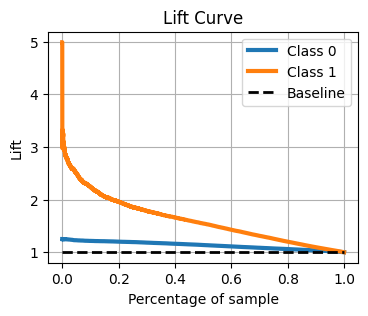

In [39]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('71_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [40]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [41]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('71_REPORT_importance_gain.csv'), index=True)

In [42]:
feat_impgain.head()

,importance
urban_flag,320.536499
LowDoc,95.444710
menc_clus_NAICS,81.147156
DisbursementGross,50.039261
franchise_flag,23.521606


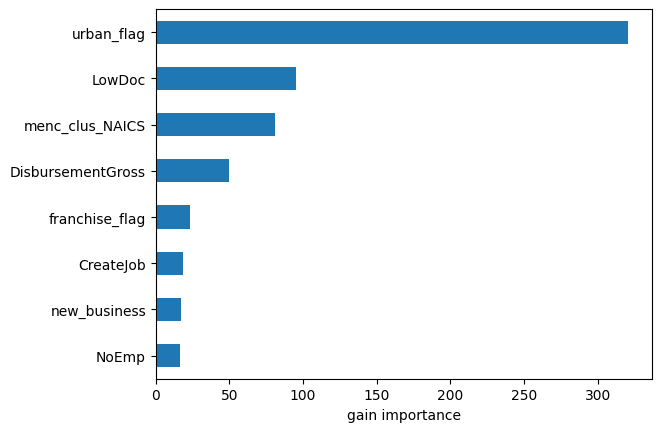

In [43]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('71_PLOT_importance_gain.png'))

##### Permutation Importance

In [44]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [45]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [46]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,menc_clus_NAICS,0.076624,0.076624
3,DisbursementGross,0.066281,0.066281
5,urban_flag,0.036324,0.036324
1,CreateJob,0.021443,0.021443
2,LowDoc,0.014497,0.014497


In [47]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('71_DATA_importance_perturb.csv'),
            index=False)

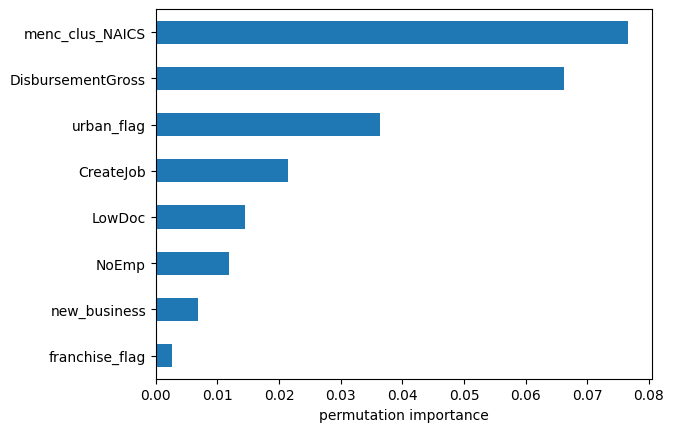

In [48]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('71_PLOT_importance_perturb.png'))

## PDP Plot - NAICS mean encoded

In [49]:
results = partial_dependence(xgb_model, train_df[predictor_features], ['menc_clus_NAICS'])
pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})

In [50]:
plt.close()

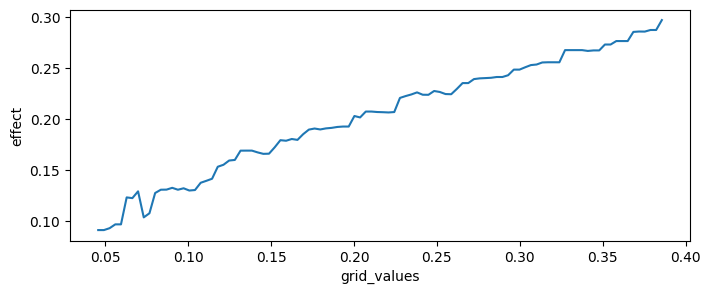

In [51]:
fig, ax = plt.subplots(figsize = (8, 3))
pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax)
ax.set_ylabel('effect')
fig.savefig(Path(setup.temp_path).joinpath('71_PLOT_pdp_naics_meanenc.png'),
               bbox_inches='tight')

## NAICS variation plot

In [52]:
sba_loans['cluster_desc'] = ''
naics_info = sg_plot.naics_variance_data(sba_loans,
                                        naics_sector_feat='cluster',
                                        naics_sector_desc_feat='cluster_desc')

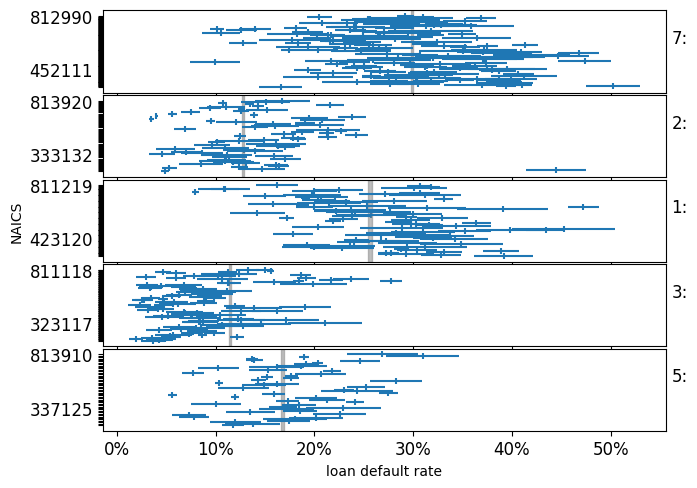

In [53]:
# Plot higher volume NAICS
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count'] > 150],
                                  naics_sector_feat='cluster',
                                  naics_sector_desc_feat='cluster_desc',
                                  num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('71_PLOT_naics_counts_rates_150.png'),
           bbox_inches='tight')

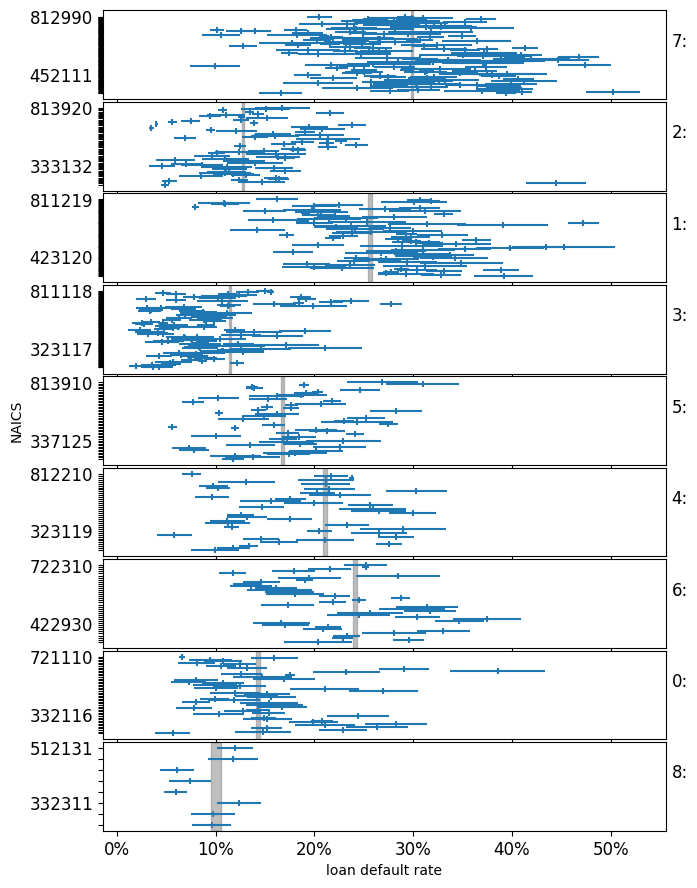

In [54]:
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count'] > 150],
                                  naics_sector_feat='cluster',
                                  naics_sector_desc_feat='cluster_desc',
                                  xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('71_PLOT_naics_counts_rates_150_all.png'),
           bbox_inches='tight')

In [55]:
lm_cluster = ols('target ~ C(cluster)',data=sba_loans).fit()
res_cluster = sm.stats.anova_lm(lm_cluster, typ=1)
res_cluster

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),8.0,3497.328013,437.166002,2789.527815,0.0
Residual,688072.0,107832.473832,0.156717,NaN,NaN


In [56]:
res_cluster['sum_sq'].transform(lambda x: x/x.sum())

C(cluster)    0.031414
Residual      0.968586
Name: sum_sq, dtype: float64